In [1]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
from numpy import mean
from numpy import std
import matplotlib.ticker as ticker
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.linear_model import ElasticNet
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
import missingno as msno 
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

## 1. Data Preprocessing 

In [2]:
data=pd.read_csv('Hospital_Inpatient_Discharges__SPARCS_De-Identified___2015.csv',low_memory=False)
print(data.dtypes)
data.head(3)

Health Service Area                     object
Hospital County                         object
Operating Certificate Number           float64
Facility Id                            float64
Facility Name                           object
Age Group                               object
Zip Code - 3 digits                     object
Gender                                  object
Race                                    object
Ethnicity                               object
Length of Stay                          object
Type of Admission                       object
Patient Disposition                     object
Discharge Year                           int64
CCS Diagnosis Code                       int64
CCS Diagnosis Description               object
CCS Procedure Code                       int64
CCS Procedure Description               object
APR DRG Code                             int64
APR DRG Description                     object
APR MDC Code                             int64
APR MDC Descr

,Health Service Area,Hospital County,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Private Health Insurance,NaN,0,N,Y,5333.90,4818.42
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Moderate,Medical,Medicare,NaN,NaN,0,N,Y,4865.99,4588.78
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Private Health Insurance,NaN,0,N,Y,5901.54,5559.56


In [54]:
## viewing categorical value counts of non-numeric columns
for i in data.select_dtypes('object').columns:
    print(data[i].value_counts(dropna=False))

New York City      1091269
Long Island         339039
Hudson Valley       245594
Capital/Adirond     167130
Western NY          163826
Central NY          158094
Finger Lakes        146342
Southern Tier        30173
NaN                   5464
Name: Health Service Area, dtype: int64
Manhattan      400765
Kings          248475
Queens         197199
Bronx          187979
Nassau         181015
Suffolk        158024
Erie           120512
Westchester    119232
Monroe         105063
Onondaga        78336
Albany          65686
Richmond        56851
Orange          39436
Dutchess        32570
Rockland        31900
Oneida          29867
Broome          28538
Schenectady     22302
Niagara         17122
Warren          14072
Chemung         13837
Otsego          12245
Rensselaer      11945
Ontario         11919
Ulster          11339
St Lawrence     11073
Jefferson       10810
Chautauqua      10439
Clinton          9817
Saratoga         9218
Tompkins         7237
Montgomery       6902
Putnam       

Emergency        1487948
Elective          447323
Newborn           227196
Urgent            176891
Trauma              6400
Not Available       1173
Name: Type of Admission, dtype: int64
Home or Self Care                        1572079
Home w/ Home Health Services              304373
Skilled Nursing Home                      224088
Expired                                    51020
Left Against Medical Advice                47065
Inpatient Rehabilitation Facility          44544
Short-term Hospital                        40553
Hospice - Medical Facility                 12666
Psychiatric Hospital or Unit of Hosp       12096
Hospice - Home                             10742
Another Type Not Listed                     8351
Facility w/ Custodial/Supportive Care       6680
Court/Law Enforcement                       3887
Medicare Cert Long Term Care Hospital       3445
Cancer Center or Children's Hospital        2906
Hosp Basd Medicare Approved Swing Bed       1550
Federal Health Care Facility

Neonate birthwt >2499g, normal newborn or neonate w other problem    198207
Vaginal delivery                                                     147000
Septicemia & disseminated infections                                  95079
Cesarean delivery                                                     76093
Heart failure                                                         56367
Other pneumonia                                                       43010
Chronic obstructive pulmonary disease                                 40767
Knee joint replacement                                                38499
Schizophrenia                                                         35653
Cellulitis & other skin infections                                    34722
Cardiac arrhythmia & conduction disorders                             32885
Hip joint replacement                                                 32596
RENAL FAILURE                                                         29228
Kidney & uri

NaN                          762285
Medicaid                     555269
Self-Pay                     365769
Medicare                     336724
Private Health Insurance     161707
Blue Cross/Blue Shield       124448
Miscellaneous/Other           16245
Federal/State/Local/VA        10788
Unknown                        8722
Managed Care, Unspecified      4163
Department of Corrections       811
Name: Payment Typology 2, dtype: int64
NaN                          1645513
Self-Pay                      479742
Medicaid                      124736
Private Health Insurance       34861
Blue Cross/Blue Shield         21466
Medicare                       18976
Unknown                        16968
Federal/State/Local/VA          3274
Managed Care, Unspecified        846
Miscellaneous/Other              529
Department of Corrections         20
Name: Payment Typology 3, dtype: int64
N    2343118
Y       3813
Name: Abortion Edit Indicator, dtype: int64
Y    1369611
N     977320
Name: Emergency Departm

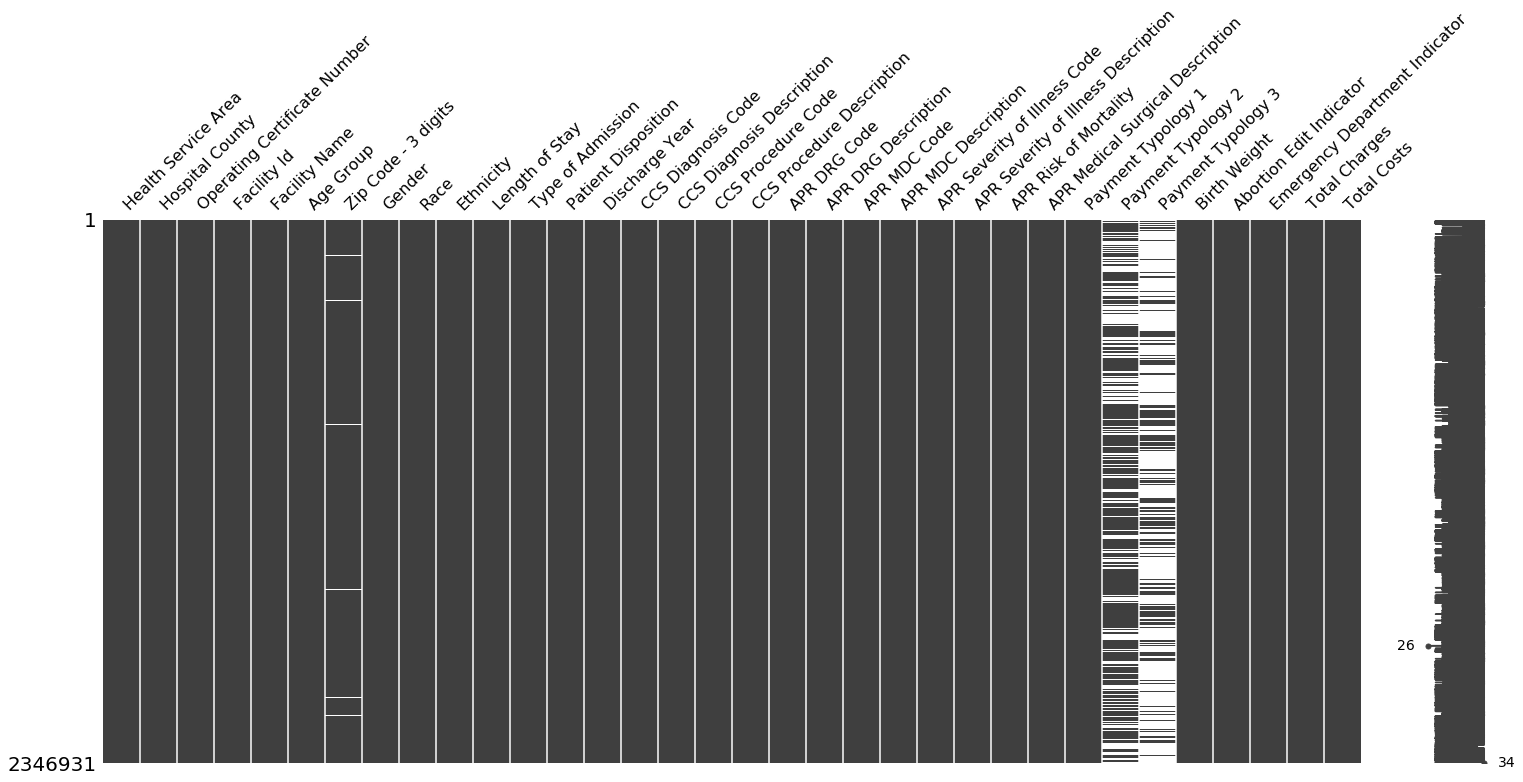

In [68]:
msno.matrix(data) 

#### Missing Data
Findings:
1. Payment typology 3 contains majority of missing information. Out of 2,346,931 records 1,645,513 (70%) are missing. This feature is unreliability collected as the result of any number of reasons and should not me included in modeling. Because class unkown had been already collected it seems improper to call the NAN unkowns

2. Payment typology 2 contains lots of missing information. 33% of records are missing. The 33% of NaN are combined with the unkown tag

In [3]:
data=data.drop(['Payment Typology 3','Discharge Year'],axis=1)
data['Payment Typology 2']=data['Payment Typology 2'].fillna('Unknown')

In [4]:
## fill rest of NAN with mode, (there are very little in rest of columns)
for column in data:
    data[column].fillna(data[column].mode()[0], inplace=True) # filling NAN with mode of column

In [5]:
## changing column data types 
for i in data.select_dtypes('object').columns:
    if i not in ['Length of Stay','CDS Diagnosis Code','CCS Procedure Code','APR DRG Code','APR MDC Code','APR Severity of Illness Code','Birth Weight','Total Charges','Total Costs']:
        data[i]=data[i].astype('category')

In [6]:
# Length of stay should be numeric 
data['Length of Stay']=np.where(data['Length of Stay']=='120 +','130',data['Length of Stay'])
data['Length of Stay']=pd.to_numeric(data['Length of Stay'])

In [7]:
data.dtypes

Health Service Area                    category
Hospital County                        category
Operating Certificate Number            float64
Facility Id                             float64
Facility Name                          category
Age Group                              category
Zip Code - 3 digits                    category
Gender                                 category
Race                                   category
Ethnicity                              category
Length of Stay                            int64
Type of Admission                      category
Patient Disposition                    category
CCS Diagnosis Code                        int64
CCS Diagnosis Description              category
CCS Procedure Code                        int64
CCS Procedure Description              category
APR DRG Code                              int64
APR DRG Description                    category
APR MDC Code                              int64
APR MDC Description                    c

In [30]:
## removing redudant information columns or uneeded information columns
data=data.drop(['Operating Certificate Number','Facility Name'],axis=1)

In [31]:
data[['APR DRG Description','APR Medical Surgical Description','CCS Diagnosis Description','CCS Procedure Description']].head()

,APR DRG Description,APR Medical Surgical Description,CCS Diagnosis Description,CCS Procedure Description
0,Other pneumonia,Medical,Pneumonia (except that caused by tuberculosis ...,NO PROC
1,Hypovolemia & related electrolyte disorders,Medical,Fluid and electrolyte disorders,NO PROC
2,Other pneumonia,Medical,Pneumonia (except that caused by tuberculosis ...,ELECTROCARDIOGRAM
3,"Other gastroenteritis, nausa & vomiting",Medical,Fluid and electrolyte disorders,NO PROC
4,Other pneumonia,Medical,Pneumonia (except that caused by tuberculosis ...,NO PROC


## 2. Exploratory Data analysis
- Plots of some correlations with prediction task
- visualization of correlations of the desired task

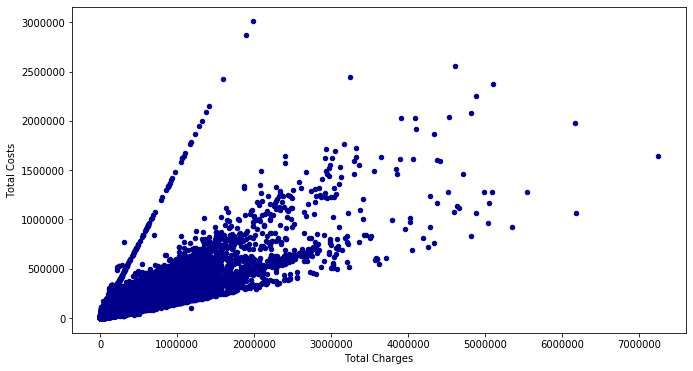

In [48]:
data.plot('Total Charges','Total Costs',kind='scatter',figsize=[11,6],color='darkblue')

In [13]:
(data['Total Charges']-data['Total Costs']).mean()

28482.271398849905

Text(0, 0.5, 'Probability Density')

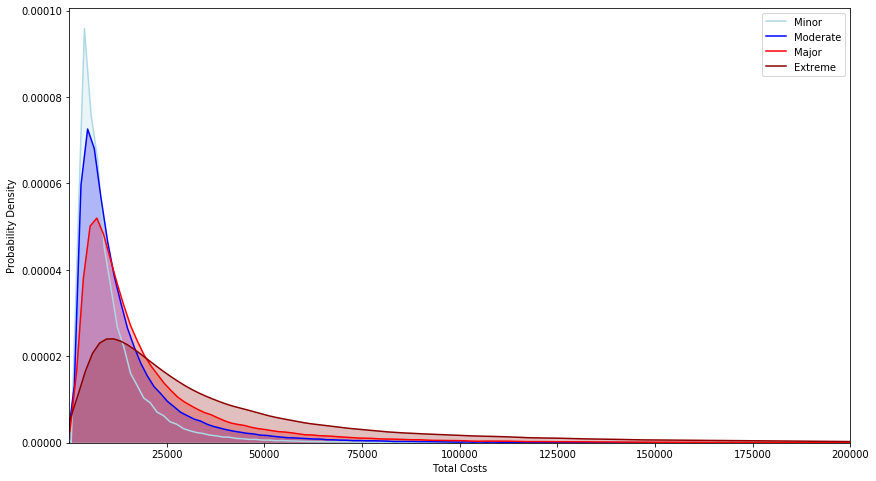

In [12]:
vis_data=data[(np.abs(stats.zscore(data['Total Costs'])) < 7)]
plt.figure(figsize=(14,8))
sns.kdeplot(vis_data.loc[(vis_data['APR Risk of Mortality']=='Minor'), 
            'Total Costs'], color='lightblue', shade=True, Label='Minor').set(xlim=(1, 200000)) 

sns.kdeplot(vis_data.loc[(vis_data['APR Risk of Mortality']=='Moderate'), 
            'Total Costs'], color='blue', shade=True, Label='Moderate')

sns.kdeplot(vis_data.loc[(vis_data['APR Risk of Mortality']=='Major'), 
            'Total Costs'], color='red', shade=True, Label='Major')

sns.kdeplot(vis_data.loc[(vis_data['APR Risk of Mortality']=='Extreme'), 
            'Total Costs'], color='darkred', shade=True, Label='Extreme')
plt.xlabel('Total Costs') 
plt.ylabel('Probability Density') 
#fig.savefig('test2png.png', dpi=100)

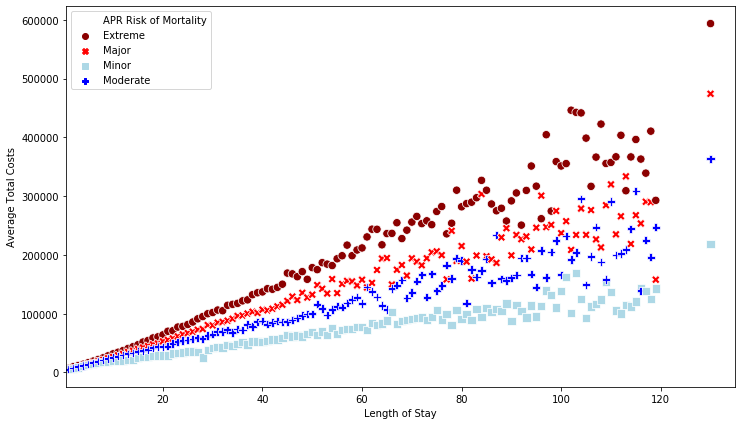

In [58]:
avg_len_stay=data.groupby(['Length of Stay','APR Risk of Mortality'])['Total Costs'].mean().reset_index() 
a4_dims = (12, 7)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.scatterplot(x='Length of Stay', y='Total Costs', data=avg_len_stay, hue="APR Risk of Mortality",s=70,style="APR Risk of Mortality",
                palette ={"Extreme": "darkred", "Major": 'red', "Moderate": "blue","Minor":"lightblue"},ax=ax)
ax.set_xlim(.5,135)
plt.ylabel("Average Total Costs")
plt.savefig("Length of stay by APR Risk.pdf")

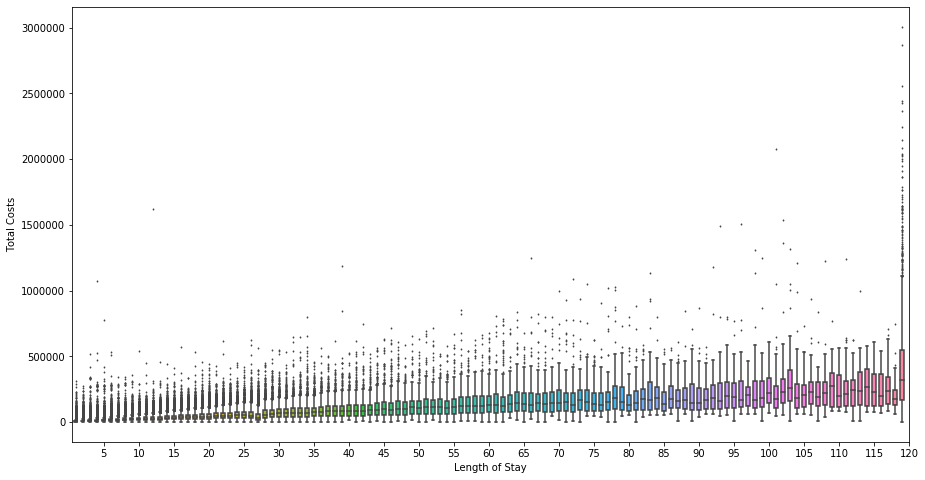

In [60]:
a4_dims = (15, 8)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.boxplot(y = 'Total Costs', x= 'Length of Stay', data = data,saturation=5,fliersize=1,width=0.5) 
ax.set_xlim(.5,120)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.savefig("Length of stay.pdf",bbox_inches='tight')

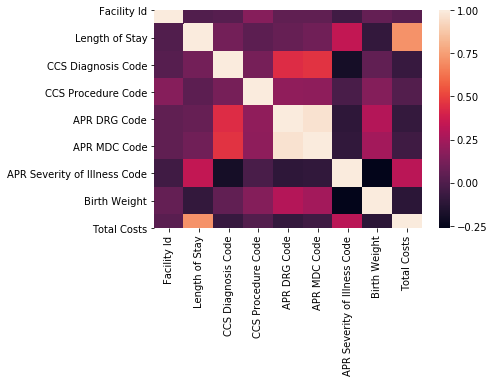

In [177]:
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### 3. Modeling 
- Formating the data into modeling friendly lyayout. Using one hot ecoding, dropping redudant features.
- Running group cross validation to insure the train and test do not have the same facility ID
- Using Elastic Net regression and Decision tree regression
- Visualising feature importance

#### 3.1 Preprocessing data into Modeling format

In [8]:
## formating data for modeling
Modeling_data=data.drop(['Health Service Area','Hospital County',
                         'CCS Diagnosis Description','CCS Procedure Description',
                        'APR DRG Description','APR DRG Code','APR MDC Description','APR Severity of Illness Description',
                        'APR Medical Surgical Description','APR MDC Code'],axis=1)
print(Modeling_data.dtypes)
Modeling_data.head()

Operating Certificate Number       float64
Facility Id                        float64
Facility Name                     category
Age Group                         category
Zip Code - 3 digits               category
Gender                            category
Race                              category
Ethnicity                         category
Length of Stay                       int64
Type of Admission                 category
Patient Disposition               category
CCS Diagnosis Code                   int64
CCS Procedure Code                   int64
APR Severity of Illness Code         int64
APR Risk of Mortality             category
Payment Typology 1                category
Payment Typology 2                category
Birth Weight                         int64
Abortion Edit Indicator           category
Emergency Department Indicator    category
Total Charges                      float64
Total Costs                        float64
dtype: object


,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,...,CCS Procedure Code,APR Severity of Illness Code,APR Risk of Mortality,Payment Typology 1,Payment Typology 2,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,4,Urgent,...,0,2,Minor,Medicare,Private Health Insurance,0,N,Y,5333.90,4818.42
1,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,4,Elective,...,0,2,Moderate,Medicare,Unknown,0,N,Y,4865.99,4588.78
2,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,4,Urgent,...,202,1,Minor,Medicare,Private Health Insurance,0,N,Y,5901.54,5559.56
3,226700.0,37.0,Cuba Memorial Hospital Inc,50 to 69,147,F,White,Not Span/Hispanic,2,Elective,...,0,2,Minor,Medicare,Unknown,0,N,Y,3619.08,3567.25
4,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,M,White,Not Span/Hispanic,2,Elective,...,0,1,Moderate,Medicare,Blue Cross/Blue Shield,0,N,Y,3185.87,3167.89


In [9]:
## some manual encoding
replace_map = {'APR Risk of Mortality': {'Minor': 1, 'Moderate': 2, 'Major': 3, 'Extreme': 4}}
replace_map2 = {'Age Group': {'0 to 17': 1, '18 to 29': 2, '30 to 49': 3, '50 to 69': 4,'70 or Older': 5}}
Modeling_data.replace(replace_map, inplace=True)
Modeling_data.replace(replace_map2, inplace=True)
Modeling_data['APR Risk of Mortality']=pd.to_numeric(Modeling_data['APR Risk of Mortality'])
Modeling_data['Age Group']=pd.to_numeric(Modeling_data['Age Group'])

In [10]:
## one hot encoding appropriate columns
Modeling_data=pd.get_dummies(Modeling_data, columns=['CCS Diagnosis Code'], prefix = ['CCS_Diag']) # will add 263 col.
Modeling_data=pd.get_dummies(Modeling_data, columns=['CCS Procedure Code'], prefix = ['CCS_Proc']) # will ad 232 col

In [11]:
## label encoding other categorical columns 
for i in Modeling_data.select_dtypes('category').columns:
    Modeling_data[i]=LabelEncoder().fit_transform(Modeling_data[i])

In [12]:
Modeling_data.head()

,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,Length of Stay,Type of Admission,...,CCS_Proc_222,CCS_Proc_223,CCS_Proc_224,CCS_Proc_225,CCS_Proc_226,CCS_Proc_227,CCS_Proc_228,CCS_Proc_229,CCS_Proc_231,CCS_Proc_999
0,226700.0,37.0,37,5,46,0,3,1,4,5,...,0,0,0,0,0,0,0,0,0,0
1,226700.0,37.0,37,5,46,0,3,1,4,0,...,0,0,0,0,0,0,0,0,0,0
2,226700.0,37.0,37,5,46,0,3,1,4,5,...,0,0,0,0,0,0,0,0,0,0
3,226700.0,37.0,37,4,46,0,3,1,2,0,...,0,0,0,0,0,0,0,0,0,0
4,226700.0,37.0,37,5,46,1,3,1,2,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
len(Modeling_data['Facility Id'].unique()) # 213 different locations

213

In [39]:
data['Total Costs'].mean()

14732.538770813828

In [13]:
## creating training test data 70% 30% split based on facility Id
for train_idx, test_idx in GroupShuffleSplit(n_splits=2, train_size=.7, random_state=1).split(Modeling_data['Total Costs'], 
                                                                                              groups=Modeling_data['Facility Id']):
    train = Modeling_data.iloc[train_idx]
    test = Modeling_data.iloc[test_idx]

In [41]:
# checking to make sure the same facility ID are not in test
print(len(train['Facility Id'].unique())+len(test['Facility Id'].unique()))
print(not any(train['Facility Id'].isin(test['Facility Id']))) #split on ids returns true
print(train.shape,test.shape)

213
True
(1600170, 513) (746761, 513)


In [14]:
## creating the groups and modeling data
groups=train['Facility Id']
X=train.drop(['Total Costs','Facility Id','Total Charges'],axis=1)
y=train['Total Costs']

#### 3.2 Model evaluation, Performance Metrics and Feature importance
- Elastic Net regression
- Decision Tree regression
- feature importance

In [15]:
## elastic net linear regression with group k fold
rmse_elas=[]
r2_elas=[]
for train_index, test_index in GroupKFold(n_splits=5).split(X,y,groups=groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model=ElasticNet(l1_ratio=0.5,random_state=1).fit(X_train,y_train)
    rmse_elas.append(np.sqrt(mean_squared_error(y_test, model.predict(X_test)))) 
    r2_elas.append(r2_score(y_test,model.predict(X_test)))

In [16]:
## training cross validaiton performance
print("Train RMSE ",np.mean(rmse_elas),np.std(rmse_elas))
print("Train R2 ",np.mean(r2_elas),np.std(r2_elas))

Train RMSE  19670.03284388404 4342.884277523939
Train R2  0.5127217732555238 0.04918932911315836


In [17]:
## re-fitting elastic net to all the training data
model=ElasticNet(l1_ratio=0.5,random_state=1).fit(X,y)

/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


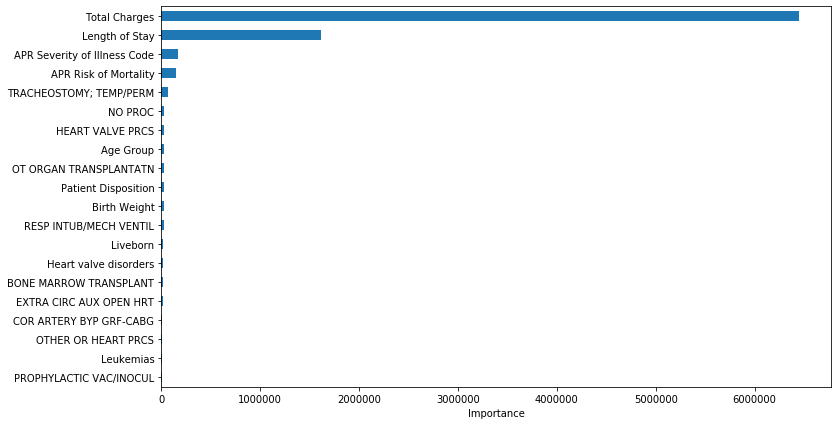

In [35]:
## getting feature importance 
feature_importance=f_regression(X, y, center=True)
feature_importance = pd.Series(index = X.columns, data =feature_importance[0])
feature_importance=feature_importance.dropna() # removing the 4 nans resulting from divide by 0
feature_importance.rename(index={'CCS_Proc_34':data[data['CCS Procedure Code']==34]['CCS Procedure Description'].values[0],
                                 'CCS_Proc_43':data[data['CCS Procedure Code']==43]['CCS Procedure Description'].values[0],
                                 'CCS_Proc_0':data[data['CCS Procedure Code']==0]['CCS Procedure Description'].values[0],
                                 'CCS_Proc_176':data[data['CCS Procedure Code']==176]['CCS Procedure Description'].values[0],
                                 'CCS_Proc_216':data[data['CCS Procedure Code']==216]['CCS Procedure Description'].values[0],
                                 'CCS_Proc_64':data[data['CCS Procedure Code']==64]['CCS Procedure Description'].values[0],
                                 'CCS_Proc_50':data[data['CCS Procedure Code']==50]['CCS Procedure Description'].values[0],
                                 'CCS_Proc_44':data[data['CCS Procedure Code']==44]['CCS Procedure Description'].values[0],
                                 'CCS_Proc_49':data[data['CCS Procedure Code']==49]['CCS Procedure Description'].values[0],
                                 'CCS_Proc_228':data[data['CCS Procedure Code']==228]['CCS Procedure Description'].values[0],
                                 'CCS_Diag_218':data[data['CCS Diagnosis Code']==218]['CCS Diagnosis Description'].values[0],
                                 'CCS_Diag_96':data[data['CCS Diagnosis Code']==96]['CCS Diagnosis Description'].values[0],
                                 'CCS_Diag_39':data[data['CCS Diagnosis Code']==39]['CCS Diagnosis Description'].values[0]},
                          inplace=True)
feature_importance.sort_values().tail(20).plot(kind = 'barh', figsize = (12,7))
plt.xlabel("Importance")
plt.savefig("Importance.pdf",bbox_inches='tight')

In [97]:
print(Modeling_data.groupby('CCS_Proc_0')['Total Costs'].mean())
print(Modeling_data.groupby('CCS_Proc_34')['Total Costs'].mean())
print(Modeling_data.groupby('CCS_Proc_216')['Total Costs'].mean())

CCS_Proc_0
0    17073.810812
1     8069.670018
Name: Total Costs, dtype: float64
CCS_Proc_34
0     14511.345452
1    158114.514777
Name: Total Costs, dtype: float64
CCS_Proc_216
0    14148.097696
1    32663.295397
Name: Total Costs, dtype: float64


In [19]:
# performance on test set
print("RMSE ",np.sqrt(mean_squared_error(test['Total Costs'], model.predict(test.drop(['Total Costs','Facility Id','Total Charges'],axis=1))))) 
print("r2 ",r2_score(test['Total Costs'],model.predict(test.drop(['Total Costs','Facility Id','Total Charges'],axis=1))))
print("MAE ",mean_absolute_error(test['Total Costs'], model.predict(test.drop(['Total Costs','Facility Id','Total Charges'],axis=1))))

RMSE  17443.467250447076
r2  0.573519470040009
MAE  7198.429871976439


In [98]:
test['Total Costs'].mean()

14677.760266444162

In [90]:
## null metrics baseline
print("RMSE Baseline ",np.sqrt(mean_squared_error(test['Total Costs'],np.repeat(test['Total Costs'].mean(), len(test['Total Costs']))))) 
print("r2 Baseline",r2_score(test['Total Costs'],np.repeat(test['Total Costs'].mean(), len(test['Total Costs']))))
print("MAE Baseline",mean_absolute_error(test['Total Costs'],np.repeat(test['Total Costs'].mean(), len(test['Total Costs']))))

RMSE Baseline  26710.57330281884
r2 Baseline -2.220446049250313e-16
MAE Baseline 11734.381078983966


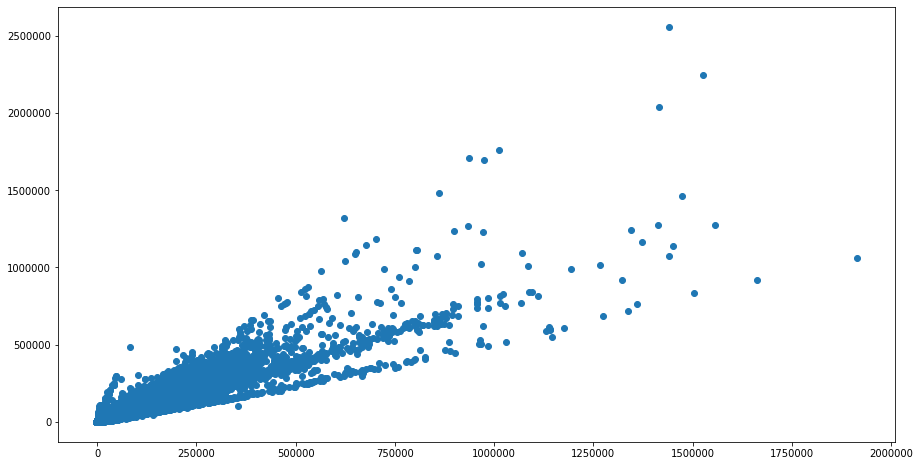

In [94]:
a4_dims = (15, 8)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = plt.scatter(model.predict(test.drop(['Total Costs','Facility Id'],axis=1)),test['Total Costs'])

In [36]:
## Deceision tree regressor
rmse_dt=[]
r2_dt=[]
for train_index, test_index in GroupKFold(n_splits=5).split(X,y,groups=groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    dt_model=DecisionTreeRegressor(random_state=1).fit(X_train,y_train)
    rmse_dt.append(np.sqrt(mean_squared_error(y_test, model.predict(X_test)))) 
    r2_dt.append(r2_score(y_test,model.predict(X_test)))

In [37]:
# training performance
print(np.mean(rmse_dt))
print(np.mean(r2_dt))

15257.761669355852
0.7030411979740104


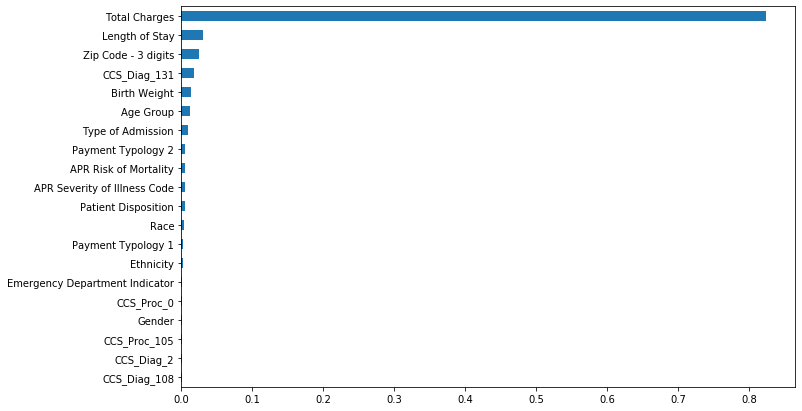

In [101]:
# feature importance
dt_model=DecisionTreeRegressor().fit(X,y)
feature_importance = pd.Series(index = X.columns, data = dt_model.feature_importances_)
feature_importance.sort_values().tail(20).plot(kind = 'barh', figsize = (11,7))

In [102]:
## Test set performance
print("RMSE ",np.sqrt(mean_squared_error(test['Total Costs'], dt_model.predict(test.drop(['Total Costs','Facility Id'],axis=1))))) 
print("r2 ",r2_score(test['Total Costs'],dt_model.predict(test.drop(['Total Costs','Facility Id'],axis=1))))
print("MAE ",(mean_absolute_error(test['Total Costs'], dt_model.predict(test.drop(['Total Costs','Facility Id'],axis=1)))))

RMSE  14760.080745916353
r2  0.6946407730775793
MAE  4808.490179153705
